In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import datetime as dt
import scipy.io

In [2]:
new_price = pd.read_csv('data/HOEP.csv')
price = pd.read_csv('data/HOEP_2002-2017.csv')
price = price.append(new_price, ignore_index=True)

new_demand = pd.read_csv('data/HourlyDemands.csv')
demand = pd.read_csv('data/HourlyDemands_2002-2017.csv')
demand = demand.append(new_demand, ignore_index=True)

In [3]:
from multiprocessing import cpu_count, Pool
num_partitions = 16
num_cores = 8

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def to_datetime(x: pd.DataFrame) -> pd.DataFrame:
    x['Date'] = pd.to_datetime(x['Date'], format='%d-%b-%y')
    return x

In [4]:
demand.head()

,Date,Hour,Total Market Demand,Ontario Demand
0,01-May-02,1,14141,14137
1,01-May-02,2,13876,13872
2,01-May-02,3,13974,13820
3,01-May-02,4,13898,13744
4,01-May-02,5,14378,14224


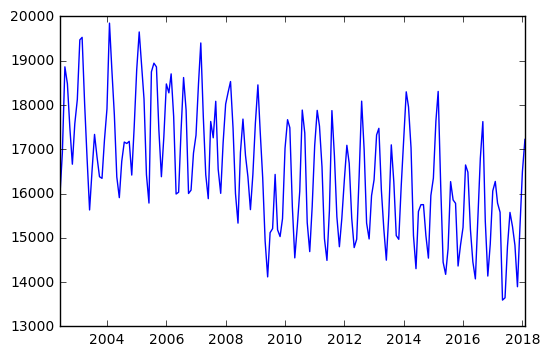

In [5]:
df = demand.copy(deep=True)
df.drop(['Total Market Demand', 'Hour'], axis=1, inplace=True)
df = parallelize_dataframe(df, to_datetime)
df.set_index('Date', drop=True, inplace=True)
df = df.resample('M').mean()
plt.plot(df)
plt.show()

In [6]:
df = demand.copy(deep=True)
df = parallelize_dataframe(df, to_datetime)
df = df.pivot(index='Date', columns='Hour', values='Ontario Demand')

In [7]:
dates = df.index.strftime("%Y-%m-%d")

scipy.io.savemat('data/z_values.mat', {'mdict': df.values})
scipy.io.savemat('data/x_values.mat', {'mdict': dates})

In [8]:
df = price.copy(deep=True)
df = parallelize_dataframe(df, to_datetime)
df = df.pivot(index='Date', columns='Hour', values='HOEP')

In [10]:
dates = df.index.strftime("%Y-%m-%d")

scipy.io.savemat('data/price_z_values.mat', {'mdict': df.values})
scipy.io.savemat('data/price_x_values.mat', {'mdict': dates})